# Pediatric Bone Age Detection using Hand X-ray
Bone age is an indicator of skeletal maturity. A child’s bone age may or may not exactly match with the child’s age according to his or her birth date. Many factors, such as, nutrition, genetics, hormones, and disease states, influence the development of the skeletal [1]. The bone age study can tell how fast or slowly a child’s skeleton is maturing [2] and it can also provide useful information on many clinical concerns. Clinicians use bone age assessment in order to evaluate the maturity of a child’s skeletal system [3]. Applications that utilize assessment of the skeletal maturity are ever growing. In addition to the medical application, the skeletal maturity assessment can be used in sports selection and forensics to the international immigrant. For example, many children seeking asylum are required to undergo a bone age study so that required resources can be facilitated for them [1].

Data set provided in the [Pediatric Bone Age Challenge(2017)](https://www.rsna.org/en/education/ai-resources-and-training/ai-image-challenge/RSNA-Pediatric-Bone-Age-Challenge-2017) organized by the Radiological Society of North America (RSNA) are used for the child’s bone age prediction. The data set can be downloaded [here](https://stanfordmedicine.app.box.com/s/4r1zwio6z6lrzk7zw3fro7ql5mnoupcv) and includes
* 12,611 hand radiographs for training
* 1,425 hand radiographs for validation
* 200 hand radiographs for testing
* A CSV file with skeletal age estimates and sex of the training and validation images labeled from the accompanying clinical radiology report provided at the time of imaging, and a separate CSV file containing skeletal age estimates and sex of the test images.

#### References
[1] https://pediatrics.aappublications.org/content/140/6/e20171486

[2] https://kidshealth.org/en/parents/xray-bone-age.html

[3] Vladimir Iglovikov, Alexander Rakhlin, Alexandr A. Kalinin, Alexey Shvets “Pediatric Bone Age Assessment Using Deep Convolutional Neural Networks”, bioRxiv 234120


### Problem statement
I am trying to answer the following two quesitons in this work.
* Which model classification or regression neural net provides better age prediction?
* Do two separate models for male and female provide better age prediction comapred to a single model for both?

In order to answer the above questions, the following models will be trained 

* Classification convolution neural net model will be trained on the traning data and skeletel age of the testing data will be predicted.
*Regression convolution neural net model will be trained on the training data and skeletel age of the testing data will be predicted.
*Best of the classification and regression convolution neural net model will be trained on the male training data and skeletel age of the of male testing data will be predicted.
*Best of the classification and regression convolution neural net model will be trained on the female training data and skeletel age of the of female testing data will be predicted.
* Results of all the above models will be analyzed and best model will be determined.

Mount google drive to get access to the data (applicable only with Google Colab)

In [21]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### <font color='blue'> **This verison of notebook contains only Exploratory Data Analysis (EDA) part and it uses sub-set of data for quick experimentation. Notebook with full deep learning model will be uploaded later after a deep learning model is completely trained.** </font>


## 1. **Data clean up and exploration**
Read training and test CSV files. The train CSV contains three columns (id, boneage, and male) and 12,611 rows. The test CSV file contains two columns(Case ID and Sex) and 200 rows. None of the rows has null value.


In [23]:
train_df = pd.read_csv('/storage/mini_data/mini_train_paperspace.csv')
test_df = pd.read_csv("/storage/mini_data/boneage-test-dataset.csv")
print (train_df.head())
print (test_df.head())

     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False
   Case ID Sex
0     4360   M
1     4361   M
2     4362   M
3     4363   M
4     4364   M


In [24]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 3 columns):
id         1457 non-null int64
boneage    1457 non-null int64
male       1457 non-null bool
dtypes: bool(1), int64(2)
memory usage: 24.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
Case ID    200 non-null int64
Sex        200 non-null object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


#### Create image file names by appending '.png' file extension to the id column

In [25]:
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 
train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


In [ ]:
# Dataframe for male only population
train_df_male = train_df[train_df['male']==True]
train_df_male.head()

In [ ]:
# Dataframe for female only population
train_df_female = train_df[train_df['male']==False]
train_df_female.head()

In [ ]:
print (train_df_male.info())
print (train_df_female.info())

**Some EDA- finding out male and female populaiton**

male      811
female    646
Name: Sex, dtype: int64


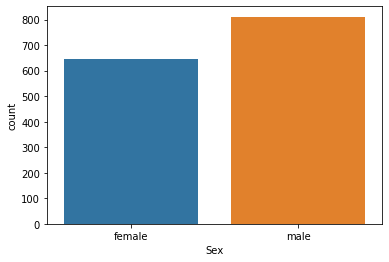

In [29]:
train_df['Sex'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['Sex'].value_counts())
sns.countplot(x = train_df['Sex'])

In [30]:
# Min, Max, and Mean of the childage in training data
train_df.describe()

,boneage
count,1457.000000
mean,129.327385
std,47.068214
min,4.000000
25%,104.000000
50%,138.000000
75%,164.000000
max,228.000000


In [31]:
# Feature normalization- total population
mean_age = train_df.boneage.mean()
std_age = train_df.boneage.std()
train_df['scale_bone_age_z'] = (train_df['boneage'] - mean_age)/(std_age)

print(train_df.head())

         id  boneage   male     Sex  scale_bone_age_z
0  1377.png      180  False  female          1.076578
1  1378.png       12  False  female         -2.492710
2  1379.png       94  False  female         -0.750557
3  1380.png      120   True    male         -0.198167
4  1381.png       82  False  female         -1.005506


In [32]:
# Feature normalization- male population
mean_age_male = train_df_male.boneage.mean()
std_age_male = train_df_male.boneage.std()
train_df_male['scale_bone_age_z'] = (train_df_male['boneage'] - mean_age_male)/(std_age_male)

print(train_df_male.head())

         id  boneage  male  scale_bone_age_z
3  1380.png      120  True         -0.287366
5  1382.png      138  True          0.083640
6  1383.png      150  True          0.330978
7  1384.png      156  True          0.454647
8  1385.png       36  True         -2.018729


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
# Feature normalization- male population
mean_age_female = train_df_female.boneage.mean()
std_age_female = train_df_female.boneage.std()
train_df_female['scale_bone_age_z'] = (train_df_female['boneage'] - mean_age_female)/(std_age_female)

print(train_df_female.head())

          id  boneage   male  scale_bone_age_z
0   1377.png      180  False          1.267509
1   1378.png       12  False         -2.503641
2   1379.png       94  False         -0.662961
4   1381.png       82  False         -0.932328
10  1388.png      126  False          0.055354


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, '# of children vs age')

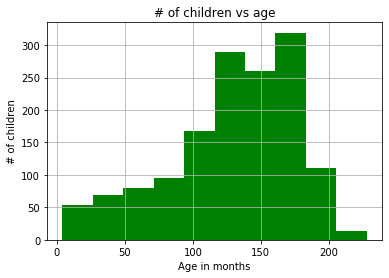

In [34]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('# of children')
plt.title('# of children vs age')

Text(0.5, 1.0, '# of children vs bone age z score')

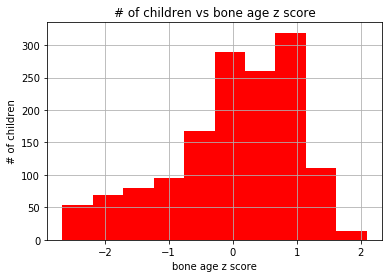

In [35]:
train_df['scale_bone_age_z'].hist(color = 'red')
plt.xlabel('bone age z score')
plt.ylabel('# of children')
plt.title('# of children vs bone age z score')

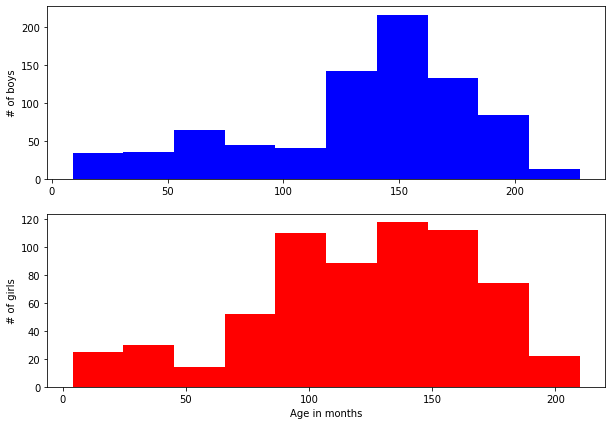

In [36]:
#distribution of age within each gender 
male = train_df[train_df['Sex'] == 'male']
female = train_df[train_df['Sex'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue')
ax[0].set_ylabel('# of boys')
ax[1].hist(female['boneage'], color = 'red')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('# of girls')
fig.set_size_inches((10,7))

In [37]:
#Splitting train dataframe into traininng and validation dataframes- total population
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)
print (df_train.info())
print (df_valid.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165 entries, 995 to 684
Data columns (total 5 columns):
id                  1165 non-null object
boneage             1165 non-null int64
male                1165 non-null bool
Sex                 1165 non-null object
scale_bone_age_z    1165 non-null float64
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 46.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 411 to 40
Data columns (total 5 columns):
id                  292 non-null object
boneage             292 non-null int64
male                292 non-null bool
Sex                 292 non-null object
scale_bone_age_z    292 non-null float64
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 11.7+ KB
None


In [38]:
#Splitting train dataframe into traininng and validation dataframes- male population
df_train_male, df_valid_male = train_test_split(train_df_male, test_size = 0.2, random_state = 0)
print (df_train_male.info())
print (df_valid_male.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 75 to 1234
Data columns (total 4 columns):
id                  648 non-null object
boneage             648 non-null int64
male                648 non-null bool
scale_bone_age_z    648 non-null float64
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 20.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 1112 to 243
Data columns (total 4 columns):
id                  163 non-null object
boneage             163 non-null int64
male                163 non-null bool
scale_bone_age_z    163 non-null float64
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 5.3+ KB
None


In [39]:
#Splitting train dataframe into traininng and validation dataframes- female population
df_train_female, df_valid_female = train_test_split(train_df_female, test_size = 0.2, random_state = 0)
print (df_train_female.info())
print (df_valid_female.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516 entries, 285 to 1255
Data columns (total 4 columns):
id                  516 non-null object
boneage             516 non-null int64
male                516 non-null bool
scale_bone_age_z    516 non-null float64
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 16.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 347 to 944
Data columns (total 4 columns):
id                  130 non-null object
boneage             130 non-null int64
male                130 non-null bool
scale_bone_age_z    130 non-null float64
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 4.2+ KB
None


In [40]:
# Check if any image file is corrupted or missing
import matplotlib.image as mpimg
import os.path
for filename, boneage, gender in train_df[['id','boneage','Sex']].values:
    if not os.path.isfile('/storage/mini_data/minidata/'+ filename): print (filename)
    try: img = mpimg.imread('/storage/mini_data/minidata/'+ filename)
    except OSError: print (filename)

## Visual inspection of some sample images


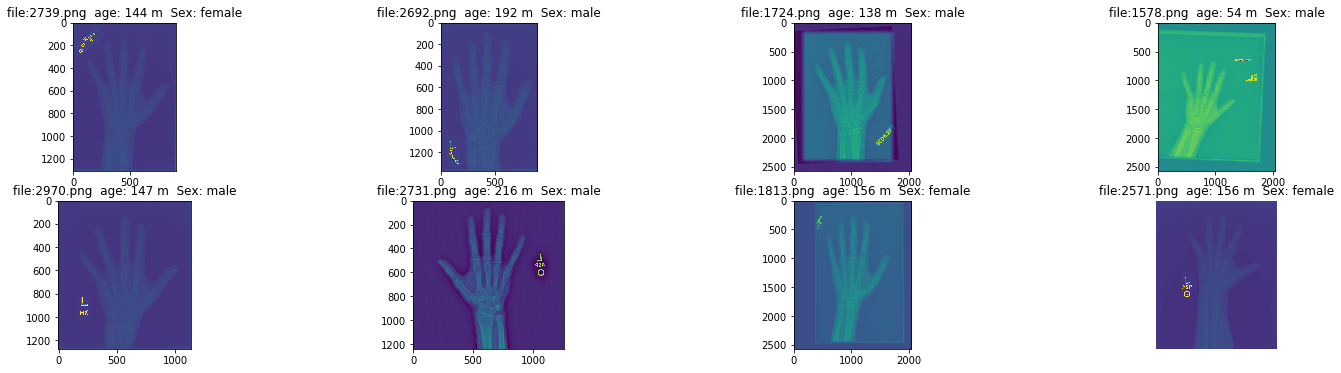

In [41]:
fig, axs = plt.subplots(2,4, figsize=(25, 6), facecolor='w', edgecolor='k')
plt_num =0
axs = axs.ravel()

for filename, boneage, Sex in train_df[['id','boneage','Sex']].sample(8).values:
    img = mpimg.imread('/storage/mini_data/minidata/'+ filename)
    
    axs[plt_num].imshow(img)
    axs[plt_num].set_title('file:{}  age: {} m  Sex: {}'.format(filename, boneage, Sex))
    plt_num += 1
plt.axis('off')
plt.show()